# Most Streamed Spotify Songs 2023

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

### 0 - Datacleaning

- Bytte namn på vissa kolumner för att underlätta komma åt dem.
- Fixade dtypes. Till str, int eller category.
- Keys kolumn: fillna med C som var den enda nyckeln som fattades.

In [30]:
df = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')

# Normalisera kolumnernas namn
rename = {'artist(s)_name':'artist',
          'danceability_%':'danceability',
          'valence_%':'valence',
          'energy_%':'energy',
          'acousticness_%':'acousticness',
          'instrumentalness_%':'instrumentalness',
          'liveness_%':'liveness',
          'speechiness_%':'speechiness'}
df = df.rename(columns=rename)

# Vissa kolumner har fel dtype. T.ex. 'streams' börde vara en numerisk datatype
df.loc[(df.streams.str.contains('BPM')), 'streams'] = 0
df.streams = df.streams.astype('int64')
df.key = df.key.fillna('C')
df.in_shazam_charts = df.in_shazam_charts.fillna(0)
df.in_shazam_charts = df.in_shazam_charts.apply(lambda x:  x.replace(',','') if isinstance(x, str) else int(x))
df.in_shazam_charts = df.in_shazam_charts.astype('int64')

# Byta 'in_deezer_playlists' till int64
df.in_deezer_playlists = df.in_deezer_playlists.fillna(0)
df.in_deezer_playlists = df.in_deezer_playlists.apply(lambda x:  x.replace(',','') if isinstance(x, str) else int(x))
df.in_deezer_playlists = df.in_deezer_playlists.astype('int64')

# Obj till string eller category
df.track_name = df.track_name.astype('string')
df.artist = df.artist.astype('string')

df.key = df.key.astype('category')
df['mode'] = df['mode'].astype('category')

df.dtypes

track_name              string[python]
artist                  string[python]
artist_count                     int64
released_year                    int64
released_month                   int64
released_day                     int64
in_spotify_playlists             int64
in_spotify_charts                int64
streams                          int64
in_apple_playlists               int64
in_apple_charts                  int64
in_deezer_playlists              int64
in_deezer_charts                 int64
in_shazam_charts                 int64
bpm                              int64
key                           category
mode                          category
danceability                     int64
valence                          int64
energy                           int64
acousticness                     int64
instrumentalness                 int64
liveness                         int64
speechiness                      int64
dtype: object

In [31]:
# Parquet
df.to_parquet('spotify-2023.parquet')
df.to_csv('spotify_2023_TopSongs.csv')

In [48]:
df.head()
df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,9.530000e+02,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,5.135979e+08,67.812172,51.908709,385.187828,2.666317,56.847849,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,5.668039e+08,86.441493,50.630241,1130.535561,6.035599,157.441749,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,1.413817e+08,13.000000,7.000000,13.000000,0.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,2.902286e+08,34.000000,38.000000,44.000000,0.000000,2.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,6.738011e+08,88.000000,87.000000,164.000000,2.000000,33.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,12367.000000,58.000000,1451.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


### 1 - Artister och låtar

* Mest 10 streamade artister: varför är de top 10, vad karaktäriserar dem?   > Priscilla/Linda

* Mest streamade låtar: spelar deras egenskaper någon roll?       > Priscilla

* Streams och låtarnas egenskaper: Vilken korrelation finns mellan dem?   > Linda

-- Slutsatser --

Korrelation streams/egenskaper, top 10 artister vs alla låtar: man kan inte se lika höga korrelationer mellan de olika egenskaper eller streams i grafen gällande alla låtar.
låtarna från de tio bästa artisterna visar några tydliga negativa eller positiva korrelationer.

T.ex. visar korrelationen mellan acousticness och energy -0.77, och mellan speechiness och liveness +0.82, att låtar med hög energi/låg acousticness är populära, eller att liveversioner av låtar också uppskattas.


Text(0.5, 1.0, 'Top 10 artister (streams)')

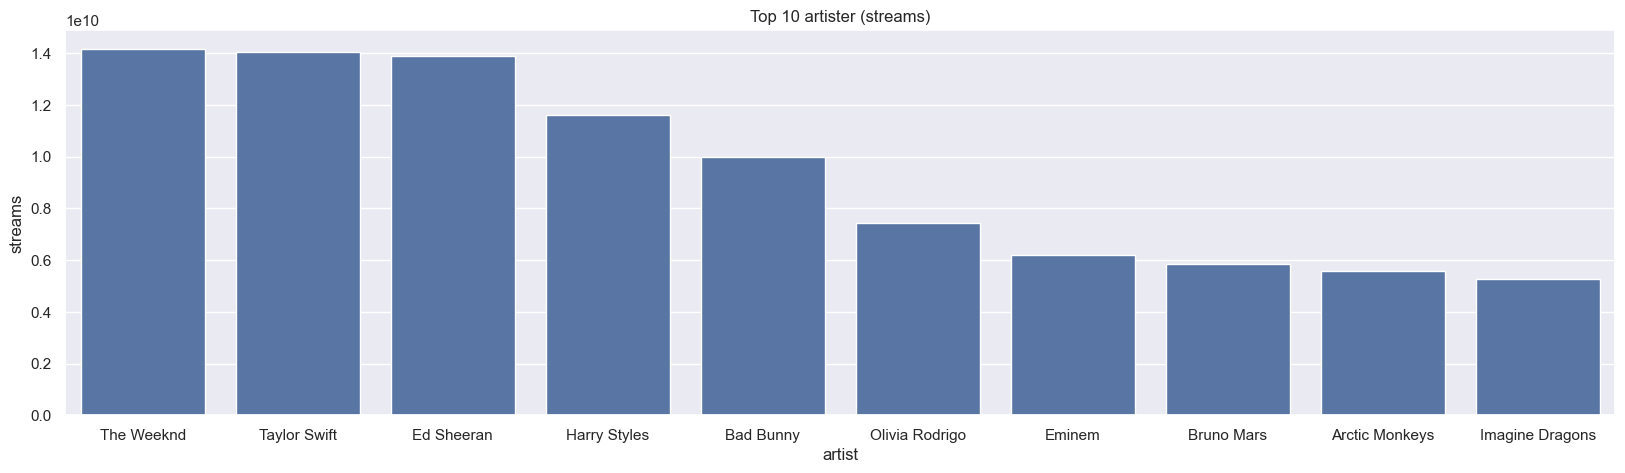

In [33]:
# Top 10 artister (streams)

# Group by artist
df_01 = df.groupby(by='artist').streams.sum().reset_index()
top10_byStream = df_01.sort_values(by='streams', ascending=False)[:10]
top10_byStream

# Plot
sns.set_theme(style='darkgrid', palette='deep')
plt.figure(figsize=(20,5))
sns.barplot(x=top10_byStream['artist'], y=top10_byStream.streams)
plt.title('Top 10 artister (streams)')

Text(0.5, 1.0, 'Correlation - Streams/Egenskaper ')

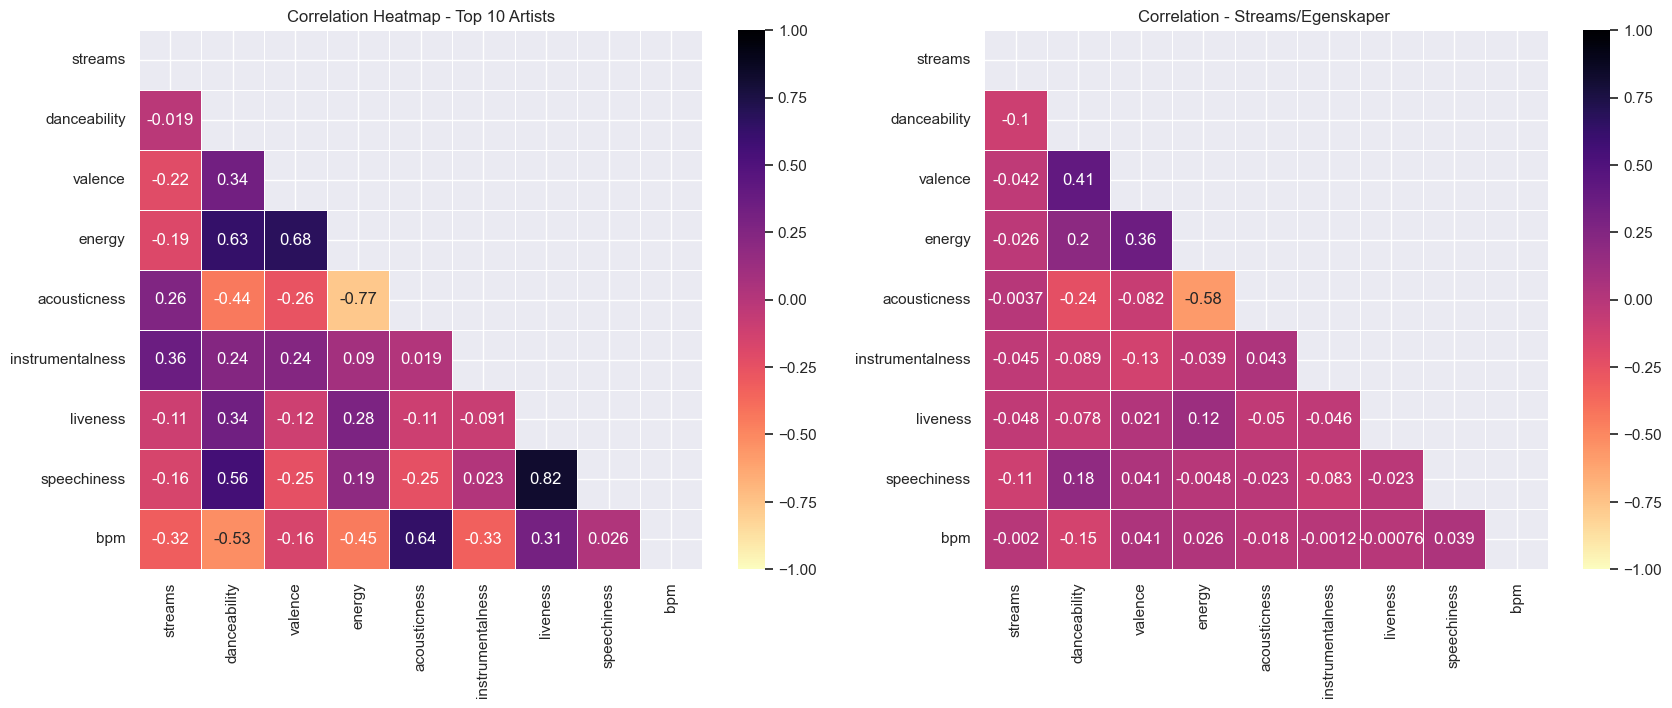

In [34]:
# Streams vs låtar egenskaper - top artister vs all

df_01 = df.groupby(by='artist').streams.sum().reset_index()
top10_byStream = df_01.sort_values(by='streams', ascending=False)[:10]
# We know top 10 artists by streams, but why are they the most popular? 
# Scatter plot with something?
# avg of the various characteristics
columns = ['artist','danceability','valence','energy','acousticness', 'instrumentalness','liveness','speechiness', 'bpm']
df_02 = df[columns]

df_02 = df_02.set_index('artist')
df_02.sort_index()
df_02 = df_02.groupby(by=df_02.index).mean().reset_index()

# merge df_02 with top 10 = mean characteristics + sum of streams
merged = pd.merge(top10_byStream, df_02)

# Plot heatmap
fig, axs = plt.subplots(1,2, figsize=(20,7))
cmap = sns.color_palette("magma_r", as_cmap=True)

# Heatmap correlation - Correlation of the top 10 artists - all characteristics + streams
dataframe = merged[['streams', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'bpm']]
mask = np.triu(np.ones_like(dataframe.corr()))
sns.heatmap(dataframe.corr(), annot=True, linewidths=.5, cmap=cmap, mask=mask, ax=axs[0], vmin=-1, vmax=1)
axs[0].set_title('Correlation Heatmap - Top 10 Artists')

dataframe = df[['streams', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'bpm']]
mask = np.triu(np.ones_like(dataframe.corr()))
sns.heatmap(dataframe.corr(), annot=True, linewidths=.5, cmap=cmap, mask=mask, ax=axs[1], vmin=-1, vmax=1)
plt.title('Correlation - Streams/Egenskaper ')

Dom 10 mest streamade låtarna i Spotify 

C:\Users\sigil\AppData\Local\Temp\ipykernel_5884\646859609.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_spotify_streams['streams'], y=top_spotify_streams['track_name'], palette='coolwarm')


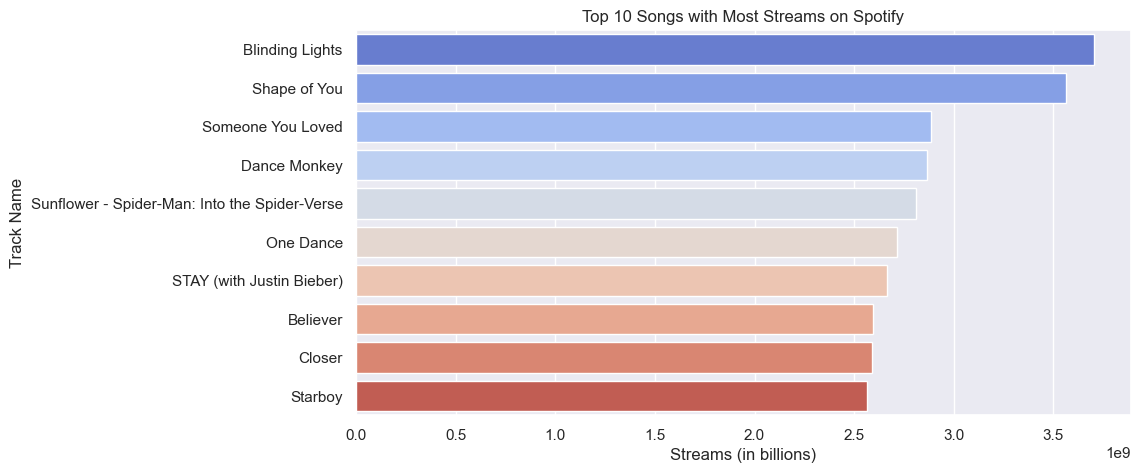

In [35]:
top_spotify_streams = df[['track_name', 'artist', 'streams']].sort_values(by='streams', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_spotify_streams['streams'], y=top_spotify_streams['track_name'], palette='coolwarm')
plt.xlabel('Streams (in billions)')
plt.ylabel('Track Name')
plt.title('Top 10 Songs with Most Streams on Spotify')
plt.show()

Visualiserat relationen mellan energi och antal streams för de mest streamade låtarna.

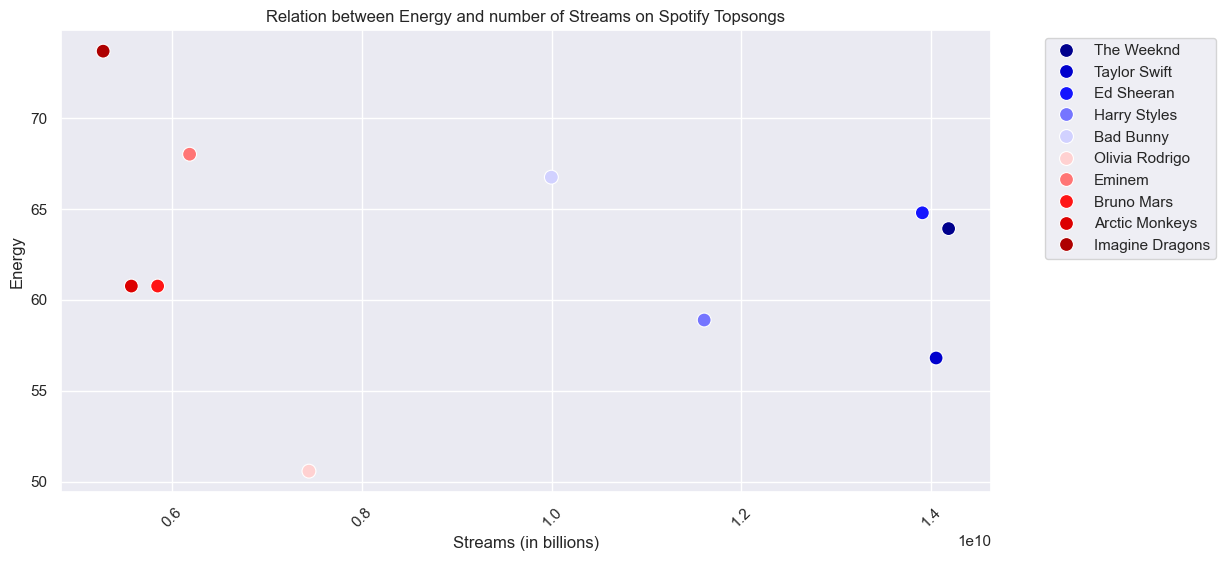

In [36]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged, x='streams', y='energy', hue='artist', palette='seismic', s=100)
plt.xlabel('Streams (in billions)')
plt.ylabel('Energy')
plt.title('Relation between Energy and number of Streams on Spotify Topsongs')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #legend för att visa låtarna
plt.show()

### 2 - BPM/andra egenskaper

- Genomsnittlig BPM och distribution.
    - För alla låtar:
        - Genomsnittlig BPM är: 122.54
        - Fördelningen visar att BPM mellan 90 och 100 samt 120 och 130 förekommer oftast.
    - Top 50 låtar:
        - Genomsnittet är 122 BPM, men flera låtar har 90-100 BPM.
    - Bottom 50 låtar:
        - Genomsnitt 118.82 BPM, 120-140 BPM förekommer mest.
    - I stort sett, är BPM mellan 90 och 150 mest använt.


- Top 50 låtar vs bottom 50 låtar: vad är skillnaden i egenskaper?

-- Slutsatser --

BPM och fördelning: genomsnittlig BPM är ganska lika i alla undersökta fall men fördelningen varierar särskilt bland de top 50 och bottom 50 låtarna. 

I stort sett verkar BPM under 90 och över 150 inte vara så populära.

När det gäller andra egenskaper är skillnaderna inte så betydliga men alla är något högre hos de bottom 50.

122.54


Text(0.5, 1.0, 'Avg bpm')

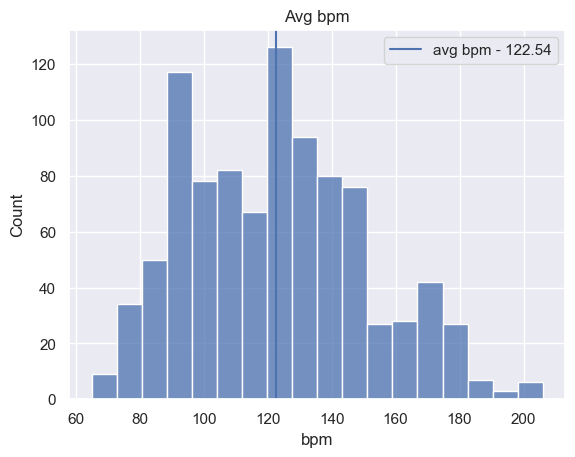

In [37]:
# Avg BPM
avg_bpm = df.bpm.mean()
print(f'{avg_bpm:.2f}')

# Distribution av BPM
sns.histplot(df.bpm)
plt.axvline(avg_bpm, label=f'avg bpm - {avg_bpm:.2f}')
plt.legend()
plt.title('Avg bpm')

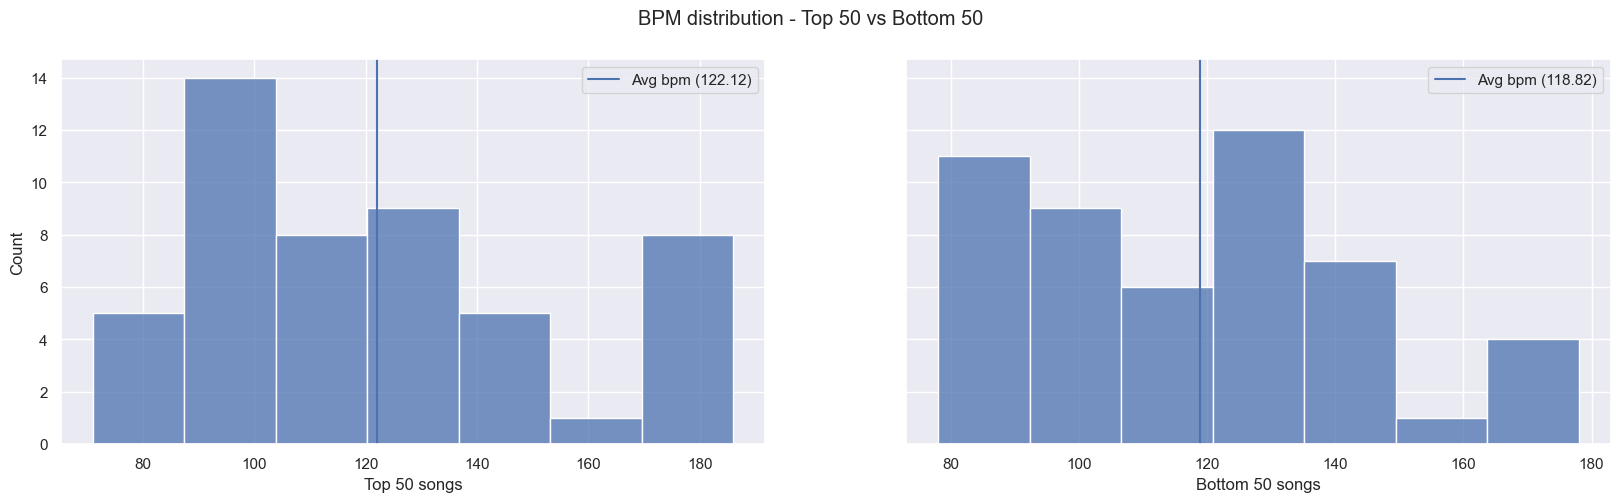

In [38]:
# Top 50 vs last 50: BPM
# Top 50 låtar
top_50_songs = df.sort_values(by='streams', ascending=False)[:50].reset_index()
top_50_avg_bpm = top_50_songs.bpm.mean()        
# Bottom 50 låtar
bottom_50_songs = df.sort_values(by='streams', ascending=False)[-50:].reset_index()
bottom_50_avg_bpm = bottom_50_songs.bpm.mean()

# Plotting
fig, axes = plt.subplots(1,2, figsize=(20,5), sharey=True)
fig.suptitle('BPM distribution - Top 50 vs Bottom 50')

sns.histplot(top_50_songs.bpm, ax=axes[0])
axes[0].axvline(x=top_50_avg_bpm, label=f'Avg bpm ({top_50_avg_bpm})')
axes[0].set_xlabel('Top 50 songs')
axes[0].legend()

sns.histplot(bottom_50_songs.bpm, ax=axes[1])
axes[1].axvline(x=bottom_50_avg_bpm, label=f'Avg bpm ({bottom_50_avg_bpm})')
axes[1].set_xlabel('Bottom 50 songs')
axes[1].legend()

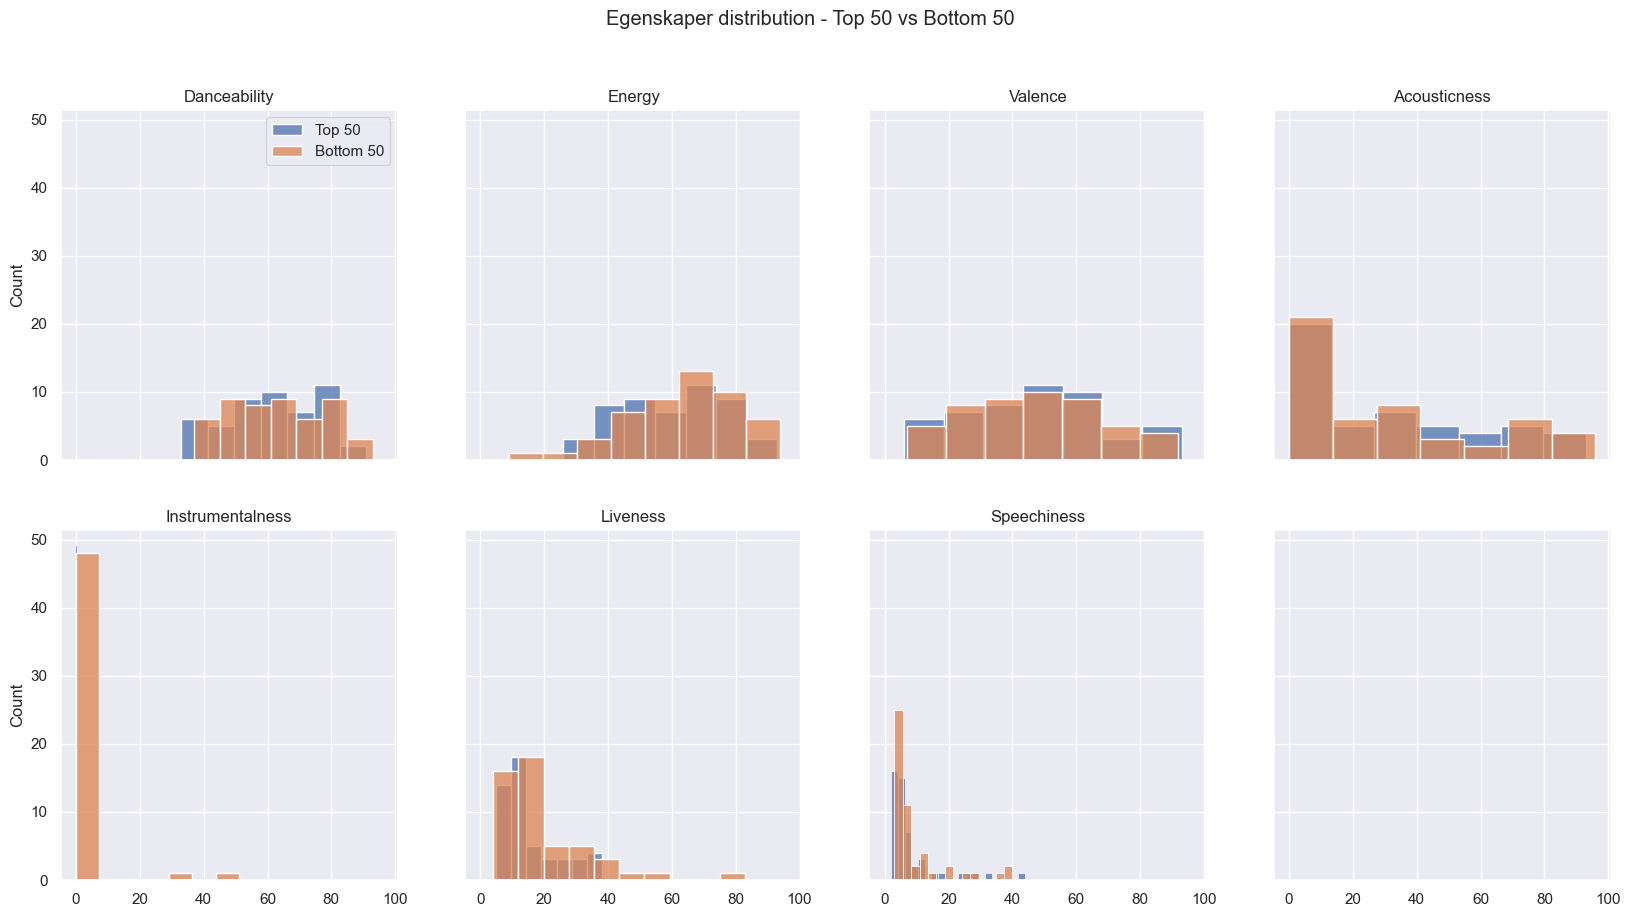

In [39]:
# Top 50 vs bottom 50: egenskaper
# Top 50 låtar
top_50_songs = df.sort_values(by='streams', ascending=False)[:50].reset_index()      
# Bottom 50 låtar
bottom_50_songs = df.sort_values(by='streams', ascending=False)[-50:].reset_index()


# Plot
fig, axes = plt.subplots(2,4, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle('Egenskaper distribution - Top 50 vs Bottom 50')

ax = axes[0,0]
sns.histplot(top_50_songs.danceability, ax=ax)
sns.histplot(bottom_50_songs.danceability, ax=ax)
ax.set_title('Danceability')
ax.legend(['Top 50', 'Bottom 50'])

ax = axes[0,1]
sns.histplot(top_50_songs.energy, ax=ax, legend=False)
sns.histplot(bottom_50_songs.energy, ax=ax, legend=False)
ax.set_title('Energy')

ax = axes[0,2]
sns.histplot(top_50_songs.valence, ax=ax, legend=False)
sns.histplot(bottom_50_songs.valence, ax=ax, legend=False)
ax.set_title('Valence')

ax = axes[0,3]
sns.histplot(top_50_songs.acousticness, ax=ax, legend=False)
sns.histplot(bottom_50_songs.acousticness, ax=ax, legend=False)
ax.set_title('Acousticness')

ax = axes[1,0]
sns.histplot(top_50_songs.instrumentalness, ax=ax, legend=True)
sns.histplot(bottom_50_songs.instrumentalness, ax=ax, legend=True)
ax.set_title('Instrumentalness')
ax.set_xlabel('')

ax = axes[1,1]
sns.histplot(top_50_songs.liveness, ax=ax, legend=False)
sns.histplot(bottom_50_songs.liveness, ax=ax, legend=False)
ax.set_title('Liveness')
ax.set_xlabel('')

ax = axes[1,2]
sns.histplot(top_50_songs.speechiness, ax=ax, legend=False)
sns.histplot(bottom_50_songs.speechiness, ax=ax, legend=False)
ax.set_title('Speechiness')
ax.set_xlabel('')

ax= axes[1,3]

In [40]:
top_50_songs.columns
top_50_avg = top_50_songs[['danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']].mean().reset_index()
bottom_50_avg = bottom_50_songs[['danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']].mean().reset_index()

top_50_avg = top_50_avg.set_index('index')
bottom_50_avg = bottom_50_avg.set_index('index')

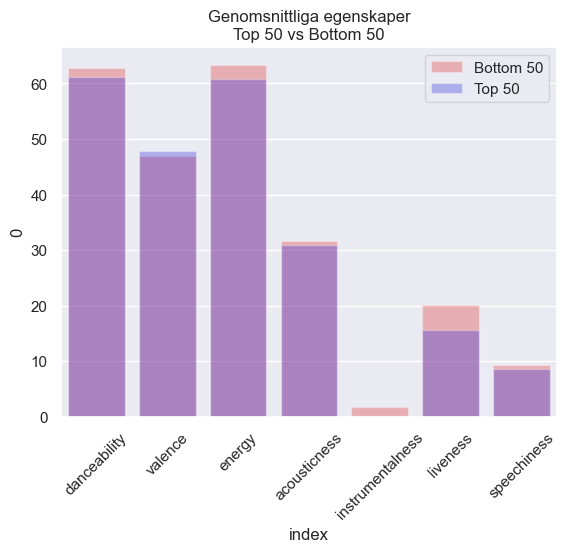

In [41]:
top_50_avg_list = top_50_songs[['danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']]
top_50_avg_list.mean()


sns.barplot(data=bottom_50_avg,x=bottom_50_avg.index, y=bottom_50_avg[0], label='Bottom 50', alpha=0.3, color='red')
sns.barplot(data=top_50_avg,x=top_50_avg.index, y=top_50_avg[0], label='Top 50', alpha=0.3, color='blue')
plt.title('Genomsnittliga egenskaper\nTop 50 vs Bottom 50')
plt.xticks(rotation=45)
plt.xticks(ticks=top_50_avg.index ,labels=top_50_avg.index, rotation=45)
plt.legend()

### 3 - Nycklar/modus

* Nyckel/modus kombination: vilken förekommer mest?    > Linda
* Vanligtvis, i musiken, är nycklar och modus kopplade till vissa känslor. T.ex. C Major låter glad osv.

    Vi kollar därför hur nyckel/modus korrelerar till valence, alltså egenskapen som mätar hur glad en låt är.  > Linda

-- Slutsatser --

C Major är den mest använda nyckeln.

D# Major är den nyckeln som förekommer minst och samtidigt den som har lågsta valence. 

C:\Users\sigil\AppData\Local\Temp\ipykernel_5884\1654219353.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_03 = df_03.groupby(by=['key','mode']).count().reset_index()


<Axes: title={'center': 'Antal per modus'}, xlabel='mode', ylabel='count'>

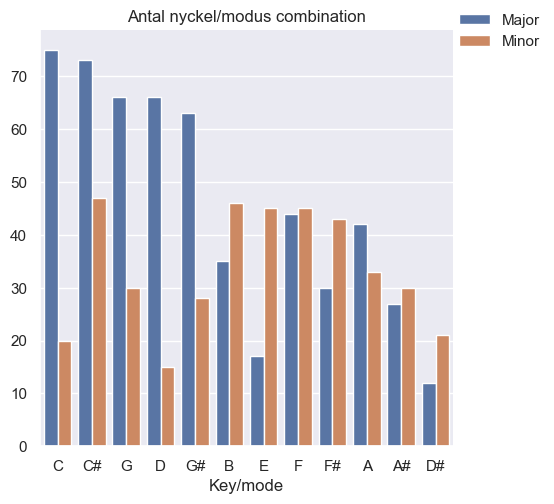

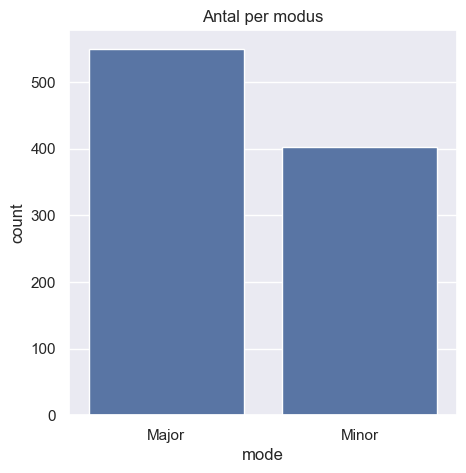

In [42]:
# Antal nycklar/modus combination
columns = ['mode', 'key', 'bpm', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
df_03 = df[['mode','key']]

df_03 = df_03.assign(count=0)           # Skapa ny kolumn 'count'

df_03 = df_03.groupby(by=['key','mode']).count().reset_index()
df_03 = df_03.sort_values(by='count', ascending=False)

# Plotting
chart = sns.catplot(data=df_03, kind='bar', x='key', y='count', hue='mode', order=list(df_03.key.unique()))
plt.title('Antal nyckel/modus combination')
chart.set_axis_labels('Key/mode','')
chart.legend.set_title('')
chart.legend.set_loc(1)

# Subplot major/minor
plt.subplots(1, figsize=(5,5))
plt.title('Antal per modus')
sns.barplot(df['mode'].value_counts())

<Axes: xlabel='key', ylabel='valence'>

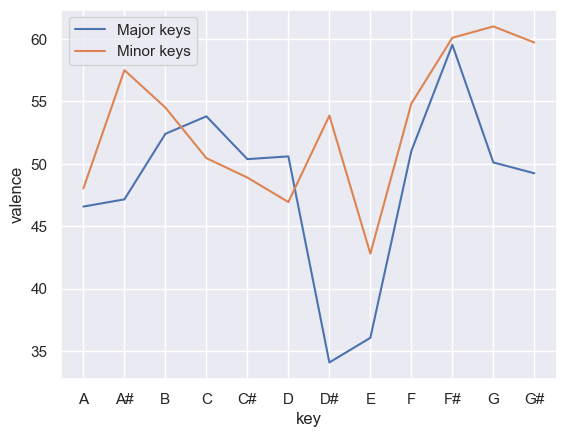

In [43]:
# Relation mode/key to valence
columns = ['mode', 'key', 'bpm', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

df_04 = df[columns]
df_04 = df_04.groupby(by=['mode','key'], observed=False).mean().reset_index()

# Plot
sns.lineplot(data=df_04.loc[(df_04['mode'] == 'Major')], x='key', y='valence', label='Major keys')
sns.lineplot(data=df_04.loc[(df_04['mode'] == 'Minor')], x='key', y='valence', label='Minor keys')

### 4 - Spellistor/charts

* Jämförelse mellan alla plattformars spellistor och charts.
Om man mäter populäritet i olika spellistor/charts, vilka låtar är mest populära hos andra plattformar?    > Priscila

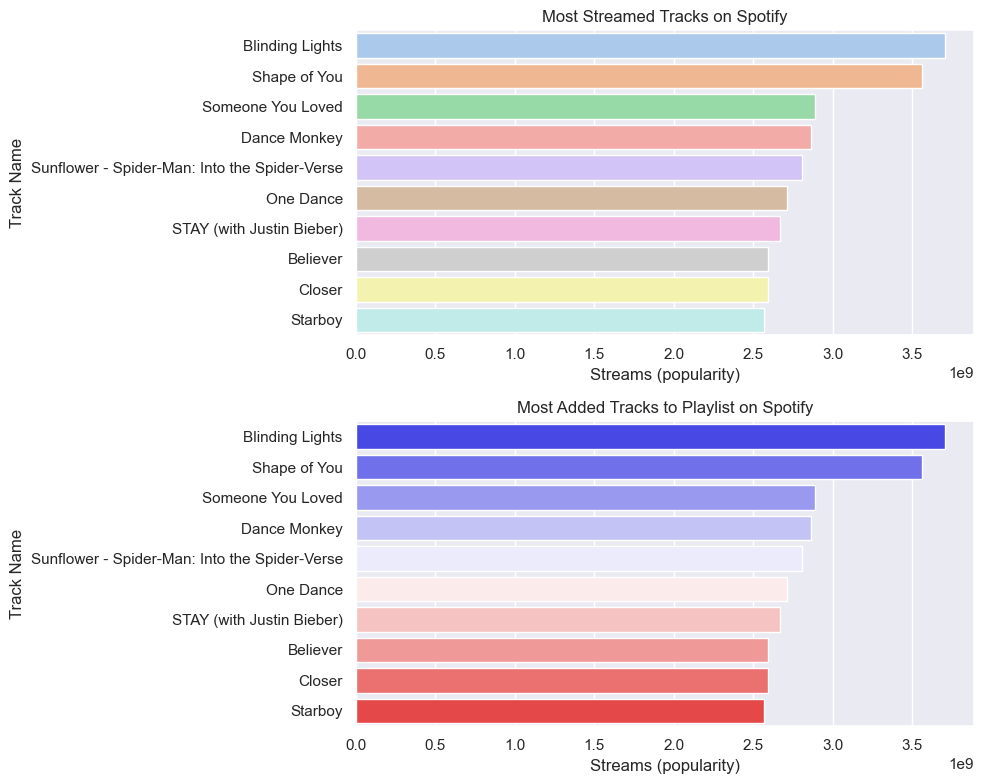

In [44]:
#Jämförelse på dom mest streamade låtarna och de mest tillagda låtarna i spellistor
fig, axes = plt.subplots(2,1, figsize=(10,8), tight_layout=True)

top_spotify_streams = df[['track_name', 'artist', 'streams']].sort_values(by='streams', ascending=False).head(10)
sns.barplot(ax=axes[0], data=top_spotify_streams, x='streams', y='track_name', hue='track_name', palette='pastel')
axes[0].set_xlabel('Streams (popularity)')
axes[0].set_ylabel('Track Name')
axes[0].set_title('Most Streamed Tracks on Spotify')

in_spotify_playlists = df[['track_name', 'artist', 'streams']].sort_values(by='streams', ascending=False).head(10)
sns.barplot(ax=axes[1], data=in_spotify_playlists, x='streams', y='track_name', hue='track_name', palette='bwr')
axes[1].set_xlabel('Streams (popularity)')
axes[1].set_ylabel('Track Name')
axes[1].set_title('Most Added Tracks to Playlist on Spotify')

plt.subplots_adjust(hspace=0.5)

Antalet spellistor som varje låt finns med i på olika musikplattformar, top 10 på Apple playlist och top 10 på Deezer playlist

Text(0, 0.5, '')

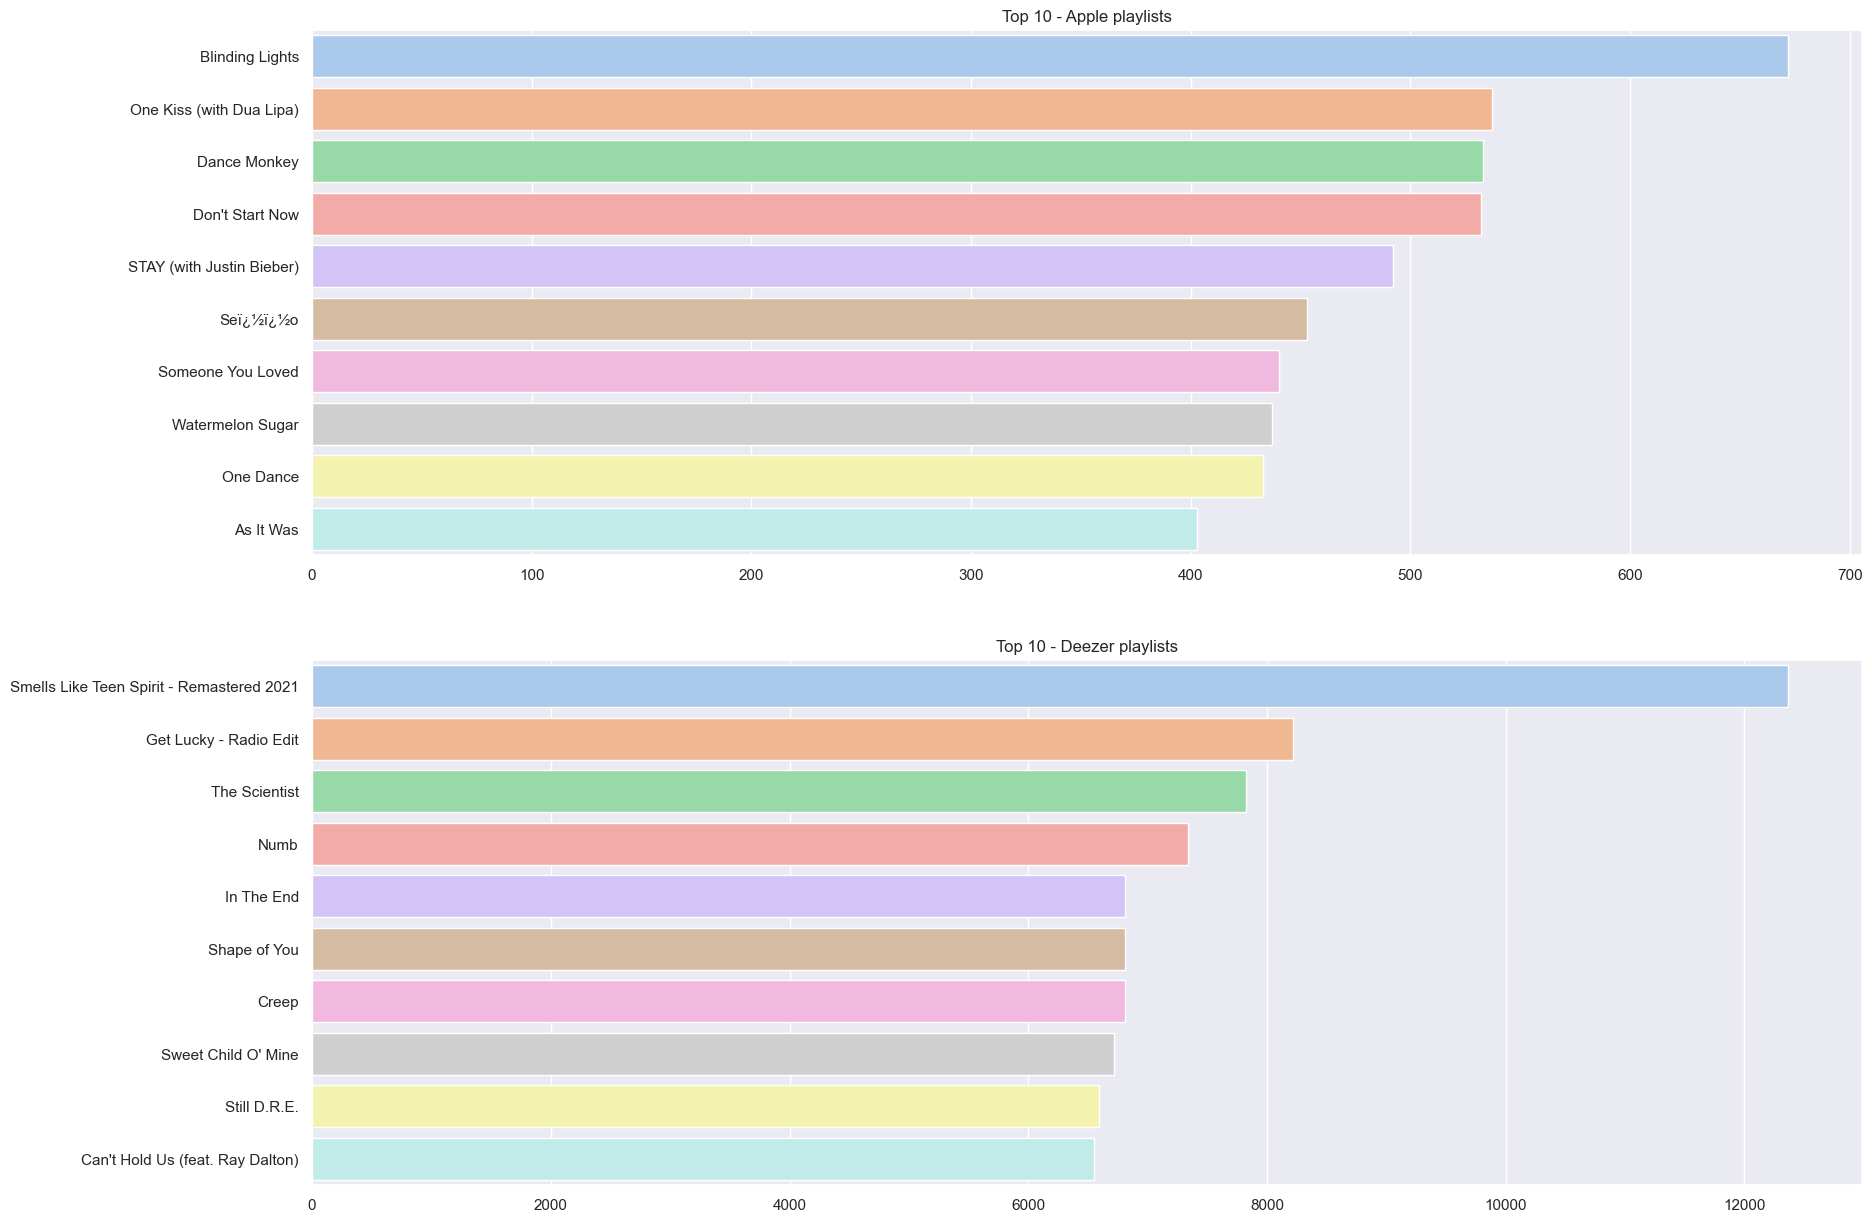

In [45]:
# Populäritet hos andra plattformar
top_10_apple_play = df[['track_name', 'artist', 'in_apple_playlists']].sort_values(by='in_apple_playlists', ascending=False).head(10)
top_10_deezer_play = df[['track_name', 'artist', 'in_deezer_playlists']].sort_values(by='in_deezer_playlists', ascending=False).head(10)

# Plot
fig, axes = plt.subplots(2,1, figsize=(20,15))

ax=axes[0]
sns.barplot(data=top_10_apple_play, y='track_name', x='in_apple_playlists', ax=ax, orient='h', hue='track_name',palette='pastel')
ax.set_title('Top 10 - Apple playlists')
ax.set_xlabel('')               ;ax.set_ylabel('')

ax=axes[1]
sns.barplot(data=top_10_deezer_play, y='track_name', x='in_deezer_playlists', ax=ax, orient='h', hue='track_name', palette='pastel')
ax.set_title('Top 10 - Deezer playlists')
ax.set_xlabel('')               ;ax.set_ylabel('')

en överblick över hur väl varje låt presterar över flera musikplattformar.

### 5 - Tid

* Antal låtar släpptes varje månad i de senaste åren.  > Linda

-- Slutsatser --

Man skulle förvänta sig att vissa perioder, såsom precis före jul eller under sommaren, skulle uppvisa en ökning i antalet släppta låtar.

Dock går det inte att identifiera ett specifikt mönster genom åren, vilket kan bero på datasets storlek och syfte. 

Med cirka 1000 låtar i datasetet är det möjligt att det inte är tillräckligt stort för att visa tydliga mönster.


In [49]:
columns = ['released_year', 'released_month']
release_time = df[columns]

# Filtrera från 2020
release_time = release_time.loc[(release_time.released_year >= 2020)]

# Skapa en ny kolumn med båda år och månad
release_time['month_year'] = release_time['released_year'].astype(str) + '-' + release_time['released_month'].astype(str)
release_time = release_time.value_counts().reset_index()
release_time = release_time.rename(columns={0:'count'})
release_time = release_time[['month_year','count']]
release_time.month_year = pd.to_datetime(release_time.month_year).dt.strftime('%Y-%m')
release_time = release_time.sort_values(by='month_year')

Text(0.5, 1.0, 'Antal låtar per månad')

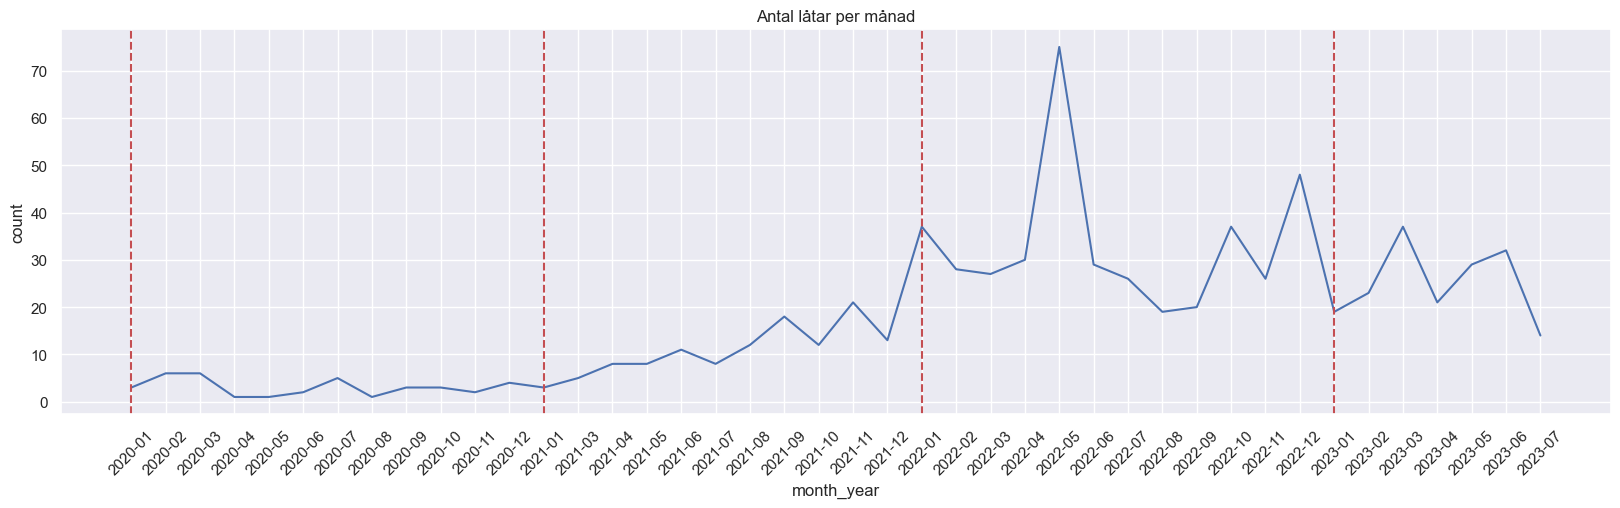

In [50]:
# Plot
plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
sns.lineplot(x= release_time.month_year, y= release_time['count'])
plt.axvline(x='2020-01', color='r', linestyle='--', label='2020')
plt.axvline(x='2021-01', color='r', linestyle='--', label='2021')
plt.axvline(x='2022-01', color='r', linestyle='--', label='2022')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023')
plt.title('Antal låtar per månad')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=474ebdcb-c925-42cf-8a37-1fd02855e9b0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>